## Import + Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Set the display options to show all columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
#Load the data
train = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv")
test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")
sample_submission = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv")

## Data Pre-processing

In [3]:
train.describe().T.style.background_gradient(cmap='Oranges').format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
patient_id,12906.00,547381.20,260404.96,100063.00,321517.00,543522.00,772671.75,999896.00
patient_zip3,12906.00,573.75,275.45,101.00,331.00,554.00,846.00,999.00
patient_age,12906.00,59.18,13.34,18.00,50.00,59.00,67.00,91.00
bmi,3941.00,28.98,5.70,14.00,24.66,28.19,32.92,85.00
population,12905.00,20744.44,13886.90,635.55,9463.90,19154.19,30021.28,71374.13
density,12905.00,1581.95,2966.31,0.92,171.86,700.34,1666.52,21172.00
age_median,12905.00,40.50,4.04,20.60,37.13,40.64,42.93,54.57
age_under_10,12905.00,11.12,1.51,0.00,10.16,11.04,12.19,17.68
age_10_to_19,12905.00,12.95,1.92,6.31,11.74,12.92,14.02,35.30
age_20s,12905.00,13.29,3.35,5.92,11.01,12.54,14.97,62.10


In [4]:
#Categorical Columns
train.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
patient_race,6521,5,White,3588
payer_type,11103,3,COMMERCIAL,6032
patient_state,12855,50,CA,2438
patient_gender,12906,1,F,12906
breast_cancer_diagnosis_code,12906,50,1749,1982
breast_cancer_diagnosis_desc,12906,50,"Malignant neoplasm of breast (female), unspeci...",1982
metastatic_cancer_diagnosis_code,12906,43,C773,7052
metastatic_first_novel_treatment,24,2,PEMBROLIZUMAB,13
metastatic_first_novel_treatment_type,24,1,Antineoplastics,24
Region,12854,4,South,3919


## Feature Engineering

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [6]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop('DiagPeriodL90D')

In [7]:
categorical_cols

Index(['patient_race', 'payer_type', 'patient_state', 'patient_gender',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division'],
      dtype='object')

In [8]:
numerical_cols

Index(['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population',
       'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'male', 'female', 'married', 'divorced', 'never_married', 'widowed',
       'family_size', 'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_ownership', 'housing_units',
       'home_value', 'rent_median', 'rent_burden', 'education_less_highschool',
       'education_highschool', 'education_some_college', 'education_bachelors',
     

In [9]:
cols = ['breast_cancer_diagnosis_code',
        'metastatic_cancer_diagnosis_code',
        'patient_zip3',
        'patient_age',
        'payer_type',
        'patient_state',
        'breast_cancer_diagnosis_desc']

## Assembling the pipeline

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

### Handle Missing data

In [11]:
class MissingDataImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median', columns=None):
        self.strategy = strategy
        self.columns = columns

    def fit(self, X, y=None):
        if self.strategy == 'median':
            if self.columns is not None:
                self.fill_values = X[self.columns].median()
            else:
                self.fill_values = X.mean()
        elif self.strategy == 'mode':
            if self.columns is not None:
                self.fill_values = X[self.columns].mode().iloc[0]
            else:
                self.fill_values = X.mode().iloc[0]
        return self

    def transform(self, X):
        if self.columns is not None:
            X_copy = X.copy()
            X_copy[self.columns] = X_copy[self.columns].fillna(self.fill_values)
            return X_copy
        else:
            return X.fillna(self.fill_values)

In [12]:
named_preprocessing_pipeline = Pipeline([
    ('medianimpute', MissingDataImputer(strategy='median', columns=['patient_zip3', 'patient_age'])), 
    ('modeimpute', MissingDataImputer(strategy='mode', columns=['breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code','payer_type','patient_state','breast_cancer_diagnosis_desc'])),
      
    ('prep', ColumnTransformer([
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         cols),
         ],
        remainder='passthrough').set_output(transform='pandas')),
    ])

named_preprocessing_pipeline  

Pipeline(steps=[('medianimpute',
                 MissingDataImputer(columns=['patient_zip3', 'patient_age'])),
                ('modeimpute',
                 MissingDataImputer(columns=['breast_cancer_diagnosis_code',
                                             'metastatic_cancer_diagnosis_code',
                                             'payer_type', 'patient_state',
                                             'breast_cancer_diagnosis_desc'],
                                    strategy='mode')),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['breast_cancer_diagnosis_code',
                                                   'metastatic_cancer_diagnosis_code',
                                                   'patient_zip3',
                                                   'patient_age', 'payer_type',
                                                   'patient_state',
                                                   'breast_cancer_diagnosis_desc'])]))])

In [13]:
from sklearn.preprocessing import  StandardScaler,RobustScaler, MinMaxScaler

# Using Standard Scaler or Robust Scaler to scale numeric variables

class StandardScalerNamed(StandardScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
    
    
class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
    
class MinMaxScalerNamed(MinMaxScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X)
        return pd.DataFrame(transformed, columns=X.columns)

In [14]:
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + [('scale',RobustScaler().set_output(transform='pandas')),])
modelling_pipeline

Pipeline(steps=[('medianimpute',
                 MissingDataImputer(columns=['patient_zip3', 'patient_age'])),
                ('modeimpute',
                 MissingDataImputer(columns=['breast_cancer_diagnosis_code',
                                             'metastatic_cancer_diagnosis_code',
                                             'payer_type', 'patient_state',
                                             'breast_cancer_diagnosis_desc'],
                                    strategy='mode')),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['breast_cancer_diagnosis_code',
                                                   'metastatic_cancer_diagnosis_code',
                                                   'patient_zip3',
                                                   'patient_age', 'payer_type',
                                                   'patient_state',
                                                   'breast_cancer_diagnosis_desc'])])),
                ('scale', RobustScaler())])

In [15]:
X = train[cols+['DiagPeriodL90D']].drop(columns=['DiagPeriodL90D'], axis=1)
y = train['DiagPeriodL90D']

In [16]:
X.head()

,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,patient_zip3,patient_age,payer_type,patient_state,breast_cancer_diagnosis_desc
0,C50919,C7989,924,84,MEDICAID,CA,Malignant neoplasm of unsp site of unspecified...
1,C50411,C773,928,62,COMMERCIAL,CA,Malig neoplm of upper-outer quadrant of right ...
2,C50112,C773,760,43,COMMERCIAL,TX,Malignant neoplasm of central portion of left ...
3,C50212,C773,926,45,COMMERCIAL,CA,Malig neoplasm of upper-inner quadrant of left...
4,1749,C773,836,55,COMMERCIAL,ID,"Malignant neoplasm of breast (female), unspeci..."


In [17]:
#checking output on train df
df_train = modelling_pipeline.fit_transform(X)
df_train.head()

,encode__breast_cancer_diagnosis_code,encode__metastatic_cancer_diagnosis_code,encode__patient_zip3,encode__patient_age,encode__payer_type,encode__patient_state,encode__breast_cancer_diagnosis_desc
0,0.586207,1.583333,0.649880,1.352941,1.0,-0.629630,0.178571
1,-0.068966,0.000000,0.659472,0.176471,0.0,-0.629630,-0.892857
2,-0.448276,0.000000,0.364508,-0.941176,0.0,0.814815,-0.500000
3,-0.310345,0.000000,0.654676,-0.823529,0.0,-0.629630,-1.178571
4,-0.827586,0.000000,0.515588,-0.235294,0.0,-0.296296,-0.678571


In [18]:
#checking output on test df
df_test = pd.DataFrame(modelling_pipeline.transform(test))
df_test.head()

,encode__breast_cancer_diagnosis_code,encode__metastatic_cancer_diagnosis_code,encode__patient_zip3,encode__patient_age,encode__payer_type,encode__patient_state,encode__breast_cancer_diagnosis_desc
0,-0.034483,0.000000,-0.179856,-0.294118,1.0,-0.222222,-1.107143
1,0.551724,0.625000,-0.455635,-0.411765,0.0,-0.444444,0.250000
2,0.517241,0.000000,0.633094,0.117647,1.0,-0.629630,0.142857
3,0.551724,0.166667,0.633094,0.294118,2.0,-0.629630,0.250000
4,-0.034483,0.166667,0.597122,-1.117647,0.0,-0.629630,-1.107143


## Modelling

### CATBoost

In [19]:
# #catboost library
# from catboost import CatBoostClassifier
# from sklearn.pipeline import make_pipeline

In [20]:
# catboost_params_optuna = {
# 'depth':2,
#  'l2_leaf_reg': 0.0687356140243106,
#  'learning_rate':0.0889501063398756,
# 'colsample_bylevel': 0.7017148360901887,
#  'subsample': 0.814719415526711,
#     'random_seed': 2024,
#     'eval_metric': 'AUC',
#     'verbose': False,
#     'loss_function': 'Logloss',
# }
# # catboost model
# cb_model = CatBoostClassifier(**catboost_params_optuna)


# cb_pipeline = make_pipeline(named_preprocessing_pipeline, cb_model)
# cb_pipeline

In [21]:
# from sklearn.model_selection import cross_validate, StratifiedKFold
# from sklearn.metrics import f1_score, roc_auc_score

# # Number of folds
# n_splits = 10

# # Adjusting parameters of StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Cross-validation results
# cv_results = []

# # Stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
    
#     cb_pipeline.fit(X_train, y_train)

#     # Predictions on the validation set
#     y_val_pred_prob = cb_pipeline.predict_proba(X_val)[:, 1]  # Predict probabilities for class 1
#     y_pred = cb_pipeline.predict(X_val)
        
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-' * 70)

#     # Results
#     cv_results.append(roc_auc)

# # Average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

### LightGBM

In [22]:
# #lgb library
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

In [23]:
# lgbm_params_optuna =  {'max_depth': 10, 
#                        'min_child_samples': 4, 
#                        'learning_rate': 0.010003952512372658, 
#                        'n_estimators': 664, 
#                        'subsample': 0.715575433872266, 
#                        'colsample_bytree': 0.765442939187372, 
#                        'reg_alpha': 0.4661178521905077, 
#                        'reg_lambda': 0.17901975780437834}
    
# # lgbm model
# lgbm_model = LGBMClassifier(**lgbm_params_optuna)

# lgbm_pipeline = make_pipeline(named_preprocessing_pipeline, lgbm_model)
# lgbm_pipeline

In [24]:
# from sklearn.metrics import log_loss

# # folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# cv_results = []


# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     lgbm_pipeline.fit(X_train,y_train)

#     y_val_pred_prob = lgbm_pipeline.predict_proba(X_val)
#     y_pred = lgbm_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     logloss = log_loss(y_val, y_val_pred_prob)
#     roc_auc = roc_auc_score(y_val, y_pred)
#     print(f'Fold {fold + 1}, AUC-Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print(f'Fold {fold + 1}, Log Loss Score on Validation Set: {logloss}')
#     print('-'*70)

#     cv_results.append(roc_auc)
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-SCORE across {n_splits} folds: {average_cv_result}')

### XGBoost

In [25]:
# from xgboost import XGBClassifier


In [26]:

# xgb_params_optuna = {'max_depth': 7, 
#                      'min_child_weight': 2, 
#                      'learning_rate': 0.010168237026903115, 
#                      'n_estimators': 411, 
#                      'subsample': 0.716159069822654, 
#                      'colsample_bytree': 0.29493256519108757, 
#                      'random_state': 2024}

# # XGBoost model
# xgb_model = XGBClassifier(**xgb_params_optuna)

# xgb_pipeline = make_pipeline(named_preprocessing_pipeline, xgb_model)
# xgb_pipeline

In [27]:
# from sklearn.model_selection import cross_validate, StratifiedKFold
# from sklearn.metrics import f1_score, roc_auc_score

# # Number of folds
# n_splits = 10

# # Adjusting parameters of StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Cross-validation results
# cv_results = []

# # Stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
    
#     xgb_pipeline.fit(X_train, y_train)

#     # Predictions on the validation set
#     y_val_pred_prob = xgb_pipeline.predict_proba(X_val)[:, 1]  # Predict probabilities for class 1
#     y_pred = xgb_pipeline.predict(X_val)
        
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-' * 70)

#     # Results
#     cv_results.append(roc_auc)

# # Average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

### Tensorflow

In [28]:
import tensorflow as tf
from sklearn.pipeline import make_pipeline
from sklearn.base import ClassifierMixin

2024-02-19 13:54:51.902465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:54:51.902569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:54:52.035012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
# class TensorFlower(BaseEstimator, ClassifierMixin):
    
#     def fit(self, x, y):
#         inputs = tf.keras.Input((x.shape[1]))
#         inputs_norm = tf.keras.layers.BatchNormalization()(inputs)
        
#         z = tf.keras.layers.Dense(32)(inputs_norm)
#         z = tf.keras.layers.BatchNormalization()(z)
#         z = tf.keras.layers.LeakyReLU()(z)
#         #z = tf.keras.layers.Dropout(.4)(z)
        
#         z = tf.keras.layers.Dense(64)(z)
#         z = tf.keras.layers.BatchNormalization()(z)
#         z = tf.keras.layers.LeakyReLU()(z)
#         #z = tf.keras.layers.Dropout(.4)(z)
        
#         z = tf.keras.layers.Dense(16)(z)
#         z = tf.keras.layers.BatchNormalization()(z)
#         z = tf.keras.layers.LeakyReLU()(z)
#         #z = tf.keras.layers.Dropout(.4)(z)
        
#         z = tf.keras.layers.Dense(4)(z)
#         z = tf.keras.layers.BatchNormalization()(z)
#         z = tf.keras.layers.LeakyReLU()(z)
#         #z = tf.keras.layers.Dropout(.4)(z)
        
#         z = tf.keras.layers.Dense(1)(z)
#         z = tf.keras.layers.BatchNormalization()(z)
#         outputs = tf.keras.activations.sigmoid(z)
        
#         self.model = tf.keras.Model(inputs, outputs)
#         self.model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.AdamW(1e-4))
        
#         self.model.fit(x.to_numpy(), y, epochs = 10, verbose = 0)
#         self.classes_ = np.unique(y)
        
#         return self
#     def predict_proba(self, x):
#         predictions = np.zeros((len(x), 2))
#         predictions[:, 1] = self.model.predict(x, verbose = 0)[:, 0]
#         predictions[:, 0] = 1 - predictions[:, 1]
#         return predictions
#     def predict(self, x):
#         return np.argmax(self.predict_proba(x), axis = 1)

In [30]:
from sklearn.utils.validation import check_X_y

class ImprovedTensorFlower(BaseEstimator, ClassifierMixin):
    
    def __init__(self, num_layers=5, num_units=325, learning_rate=0.0027059662487015864, dropout_rate=0.36038206262642924, epochs=50, batch_size=128):
        #{'num_layers': 5, 'num_units': 325, 'learning_rate': 0.0027059662487015864, 'dropout_rate': 0.36038206262642924, 'epochs': 50, 'batch_size': 128}
        self.num_layers = num_layers
        self.num_units = num_units
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        inputs = tf.keras.Input((X.shape[1]))
        x = tf.keras.layers.BatchNormalization()(inputs)
        
        for _ in range(self.num_layers):
            x = tf.keras.layers.Dense(self.num_units)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = tf.keras.layers.Dropout(self.dropout_rate)(x)
        
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        self.model = tf.keras.Model(inputs, outputs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        self.classes_ = np.unique(y)
        
        return self
    
    def predict_proba(self, X):
        predictions = self.model.predict(X, verbose=0)
        return np.hstack((1 - predictions, predictions))
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [31]:
TF_pipeline = make_pipeline(
    modelling_pipeline, 
    ImprovedTensorFlower())

TF_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('medianimpute',
                                  MissingDataImputer(columns=['patient_zip3',
                                                              'patient_age'])),
                                 ('modeimpute',
                                  MissingDataImputer(columns=['breast_cancer_diagnosis_code',
                                                              'metastatic_cancer_diagnosis_code',
                                                              'payer_type',
                                                              'patient_state',
                                                              'breast_cancer_diagnosis_desc'],
                                                     strategy='mode')),
                                 ('prep',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['breast_cancer_diagnosis_code',
                                                                    'metastatic_cancer_diagnosis_code',
                                                                    'patient_zip3',
                                                                    'patient_age',
                                                                    'payer_type',
                                                                    'patient_state',
                                                                    'breast_cancer_diagnosis_desc'])])),
                                 ('scale', RobustScaler())])),
                ('improvedtensorflower', ImprovedTensorFlower())])

In [32]:
# from sklearn.model_selection import cross_validate, StratifiedKFold
# from sklearn.metrics import f1_score, roc_auc_score

# # Number of folds
# n_splits = 10

# # Adjusting parameters of StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Cross-validation results
# cv_results = []

# # Stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
    
#     TF_pipeline.fit(X_train, y_train)

#     # Predictions on the validation set
#     y_val_pred_prob = TF_pipeline.predict_proba(X_val)[:, 1]  # Predict probabilities for class 1
#     y_pred = TF_pipeline.predict(X_val)
        
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-' * 70)

#     # Results
#     cv_results.append(roc_auc)

# # Average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

## Submission

In [33]:
# from sklearn.ensemble import VotingClassifier

In [34]:
# ensemble_model = VotingClassifier(estimators=[
#     ('xgb', xgb_pipeline),
#     ('lgb', lgbm_pipeline),
#     ('cb', cb_pipeline),
            
# ]
#                                   , voting='soft',
#                                   weights = [0.4,0.2,0.4]) 

# ensemble_model

In [35]:
# # Fit the ensemble final model
# ensemble_model.fit(X, y)

# # Create submission file with |probability predictions
# predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

# sample_submission['DiagPeriodL90D'] = predictions
# sample_submission.to_csv('submission_ensemble.csv', index=False)

In [36]:
# Fit the ensemble final model
TF_pipeline.fit(X, y)

# Create submission file with probability predictions
predictions = TF_pipeline.predict_proba(test)[:, 1]  # Use the probabilities of class 1

sample_submission['DiagPeriodL90D'] = predictions
sample_submission.to_csv('submission_TF.csv', index=False)

I0000 00:00:1708350909.135609      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [37]:
sample_submission.head(10)

,patient_id,DiagPeriodL90D
0,573710,0.770544
1,593679,0.811920
2,184532,0.784361
3,447383,0.769565
4,687972,0.798531
5,281312,0.130743
6,492714,0.785690
7,378266,0.837026
8,291550,0.832546
9,612272,0.810631


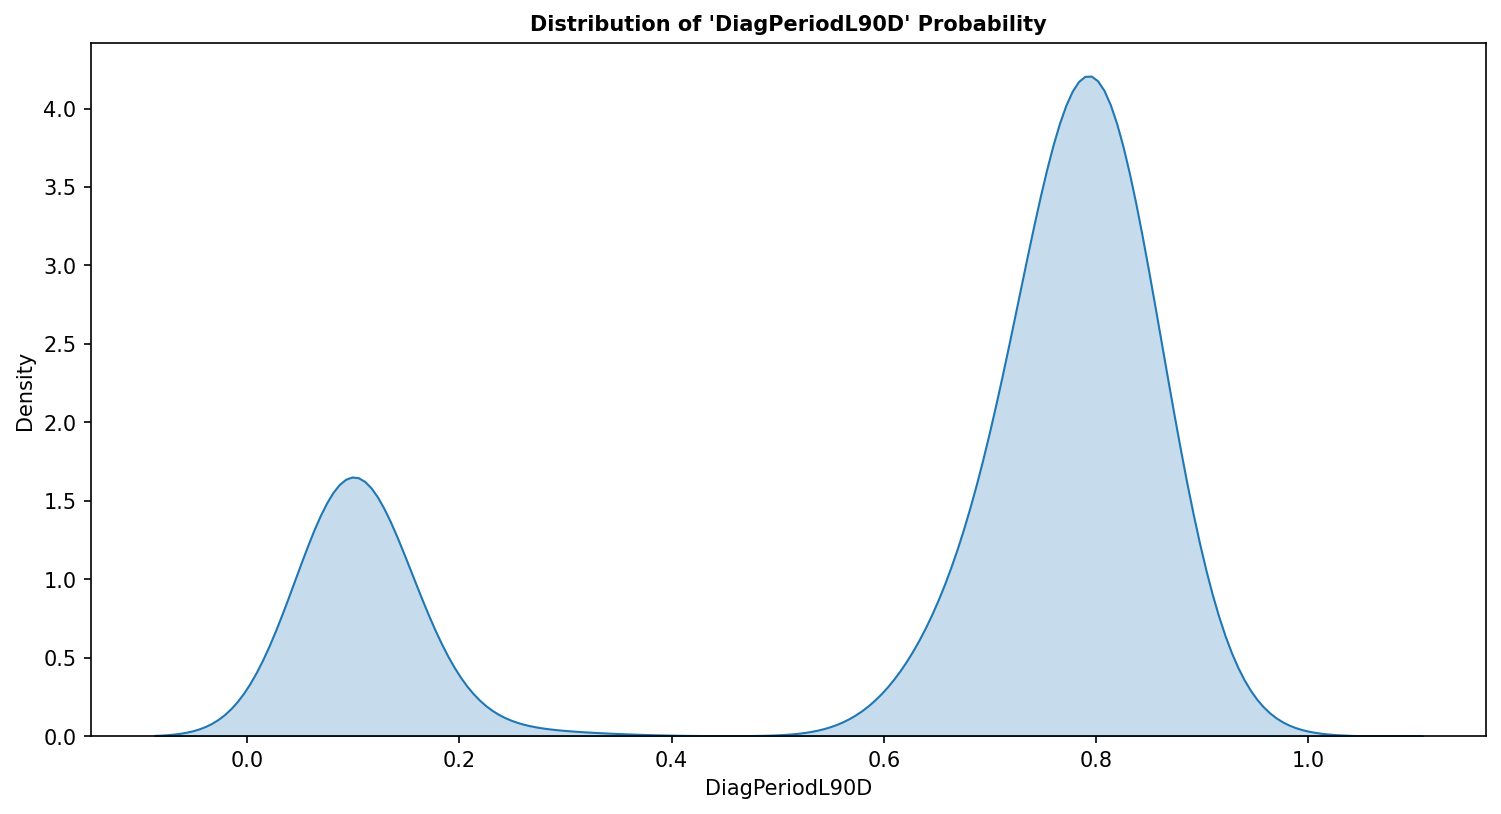

In [38]:
plt.figure(figsize = (12, 6), dpi = 150)
sns.kdeplot(sample_submission.DiagPeriodL90D, fill = True)
plt.title("Distribution of 'DiagPeriodL90D' Probability", weight = 'bold', size = 10)
plt.show()

## Hyperparameter Tuning

In [39]:
import optuna
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import warnings
# Set global warning filter
warnings.filterwarnings("ignore")

### Catboost

In [40]:
# # Suppress FutureWarnings related to is_sparse
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1989)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 2, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1.0, log=True),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'random_seed': 1989,
#         'eval_metric': 'Logloss',  # Use Logloss metric for optimization
#         'verbose': False,
#         'loss_function': 'Logloss',
#     }
    
#     cb_model = CatBoostClassifier(**params)
#     cb_pipeline = make_pipeline(named_preprocessing_pipeline, cb_model)
    

#     cv = abs(cross_val_score(cb_pipeline, X, y, cv=skf, scoring='neg_log_loss').mean())  # Use neg_log_loss
#     return cv

# study = optuna.create_study(direction='minimize')  # Use minimize for log loss
# study.optimize(objective, n_trials=50)

# best_params_cb = study.best_params
# print("Best Hyperparameters for CatBoost:", best_params_cb)

- Best Hyperparameters for CatBoost: {'iterations': 851, 'depth': 3, 'l2_leaf_reg': 0.36148603908492916, 'learning_rate': 0.02620960970067648, 'colsample_bylevel': 0.8105895399143102, 'subsample': 0.3612619832447976}
- Best is trial 33 with value: 0.46334439134951355.

### LGBM

In [41]:
# # Suppress FutureWarnings related to is_sparse
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1989)

# def objective(trial):
#     params = {
#         'objective': 'binary',  # Objective for binary classification
#         'boosting_type': 'gbdt',
#         #'device': 'gpu',
#         'metric': 'logloss',  # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'random_state': 2024,
#     }
    
#     lgbm_model = LGBMClassifier(**params)
#     lgbm_pipeline = make_pipeline(named_preprocessing_pipeline, lgbm_model)
    

#     cv = abs(cross_val_score(lgbm_pipeline, X, y, cv=skf, scoring='neg_log_loss').mean())  # Use neg_log_loss
#     return cv

# study = optuna.create_study(direction='minimize')  # Use minimize for log loss
# study.optimize(objective, n_trials=50)

# best_params_lgbm = study.best_params
# print("Best Hyperparameters for LGBM:", best_params_lgbm)

- Best Hyperparameters for LGBM: {'max_depth': 10, 'min_child_samples': 4, 'learning_rate': 0.010003952512372658, 'n_estimators': 664, 'subsample': 0.715575433872266, 'colsample_bytree': 0.765442939187372, 'reg_alpha': 0.4661178521905077, 'reg_lambda': 0.17901975780437834}
- Best is trial 42 with value: 0.46589571724041806.

### XGBoost

In [42]:
# import xgboost as xgb

# def objective_xgb(trial):
#     """Define the objective function for XGBClassifier"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'random_state': trial.suggest_categorical('random_state', [2024]),
#         'tree_method': 'hist', 
#         'device' : 'cuda',
#         'eval_metric': 'logloss',  # Evaluation metric
#         'verbosity': 2,  # Set verbosity to 0 for less output
#     }

#     xgb_model = xgb.XGBClassifier(**params)
#     xgb_pipeline = make_pipeline(named_preprocessing_pipeline, xgb_model)

#     cv = abs(cross_val_score(xgb_pipeline, X, y, cv=skf, scoring='neg_log_loss').mean())

#     return cv

# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()
            
# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_xgb, n_trials=50, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_xgb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_xgb)

-Best Hyperparameters for XGBoost: {'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.010168237026903115, 'n_estimators': 411, 'subsample': 0.716159069822654, 'colsample_bytree': 0.29493256519108757, 'random_state': 2024}
-Best is trial 13 with value: 0.4688635226511134.

### TensorFLow

In [43]:
# def objective_TF(trial):
#     """Define the objective function forTFClassifier"""

#     params = {
#         'num_layers': trial.suggest_int('num_layers', 3, 5),
#         'num_units': trial.suggest_int('num_units', 64, 256),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-3),
#         'dropout_rate': trial.suggest_uniform('dropout_rate', 0.2, 0.7),
#         'epochs': trial.suggest_int('epochs', 10, 30),
#         'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
#     }

#     TF_model = ImprovedTensorFlower(**params)
#     TF_pipeline = make_pipeline(named_preprocessing_pipeline, TF_model)

#     cv = abs(cross_val_score(TF_pipeline, X, y, cv=skf, scoring='neg_log_loss').mean())

#     return cv

# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()
            
# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_TF, n_trials=10, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_TF = study.best_params
# print("Best Hyperparameters for TensorFlow:", best_params_TF)

- Trial 8 finished with value: 0.4713476645608048 and parameters: {'num_layers': 5, 'num_units': 325, 'learning_rate': 0.0027059662487015864, 'dropout_rate': 0.36038206262642924, 'epochs': 50, 'batch_size': 128}. Best is trial 8 with value: 0.4713476645608048.